In [11]:
import hopsworks
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np

project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/549021
Connected. Call `.close()` to terminate connection gracefully.


In [12]:
try: 
    feature_view = fs.get_feature_view(name="spot58", version=1)
except:
    fg = fs.get_feature_group(name="spot58", version=1)
    query = fg.select_all()
    feature_view = fs.create_feature_view(name="spot58",
                                      version=1,
                                      description="sensor 58",
                                      query=query)

In [13]:
feature, labels = feature_view.training_data(
    description = 'spot58 training dataset',
)

features = feature[['x','y','z','temperature','magnitude']]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.72s) 
2024-05-28 16:05:40,838 WARNING: VersionWarning: Incremented version to `2`.



2024-05-28 16:05:42,997 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2024-05-28 16:05:43,199 WARNING: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



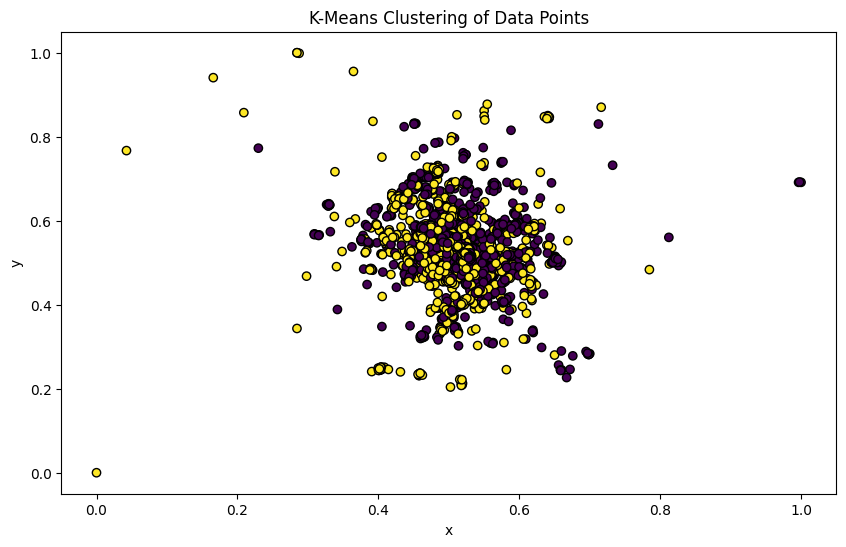

          x         y         z  temperature  magnitude  cluster
0  0.582639  0.691414  0.348315     0.581395   0.968940        0
1  0.524770  0.515817  0.528090     0.604651   0.905720        0
2  0.470408  0.718528  0.598315     0.767442   1.046684        0
3  0.525647  0.515171  0.533708     0.604651   0.909148        0
4  0.539676  0.506779  0.530899     0.767442   0.911004        0


In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



features['magnitude'] = np.sqrt(features['x']**2 + features['y']**2 + features['z']**2)

kmeans = KMeans(n_clusters=2, random_state=42)  

kmeans.fit(features)

clusters = kmeans.predict(features)

features['cluster'] = clusters

plt.figure(figsize=(10, 6))
plt.scatter(features['x'], features['y'], c=features['cluster'], cmap='viridis', marker='o', edgecolor='k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-Means Clustering of Data Points')
plt.show()

print(features.head())

cluster_counts = features['cluster'].value_counts()
anomaly_cluster = cluster_counts.idxmin()

anomalies = features[features['cluster'] == anomaly_cluster]

anomaly_indices = anomalies.index

In [15]:
features.head(20)

,x,y,z,temperature,magnitude,cluster
0,0.582639,0.691414,0.348315,0.581395,0.968940,0
1,0.524770,0.515817,0.528090,0.604651,0.905720,0
2,0.470408,0.718528,0.598315,0.767442,1.046684,0
3,0.525647,0.515171,0.533708,0.604651,0.909148,0
4,0.539676,0.506779,0.530899,0.767442,0.911004,0
5,0.524331,0.518399,0.502809,0.348837,0.892456,1
6,0.472600,0.592640,0.498596,0.325581,0.907288,1
7,0.491451,0.544222,0.471910,0.418605,0.872010,1
8,0.519947,0.518399,0.505618,0.232558,0.891478,1
9,0.525208,0.520981,0.526685,0.604651,0.908109,0


In [16]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import os
import joblib
import shutil

In [17]:
mr = project.get_model_registry()

model_dir1="spot58_k_nn"
if os.path.isdir(model_dir1) == False:
    os.mkdir(model_dir1)
joblib.dump(kmeans, model_dir1 + "/spot58_k_nn.pkl")



spot58 = mr.python.create_model(
    version=1,
    name="spot58_k_nn", 
    description="Anomaly detection- UML")

spot58.save(model_dir1)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/32959 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/549021/models/spot58_k_nn/1


Model(name: 'spot58_k_nn', version: 1)